This exercise creates a colored temperature plot for North America using AWIPS METAR observations (datatype *obs*), similar to existing products in GEMPAK and CAVE.

Found 20844 total records
Using 1697 temperature records


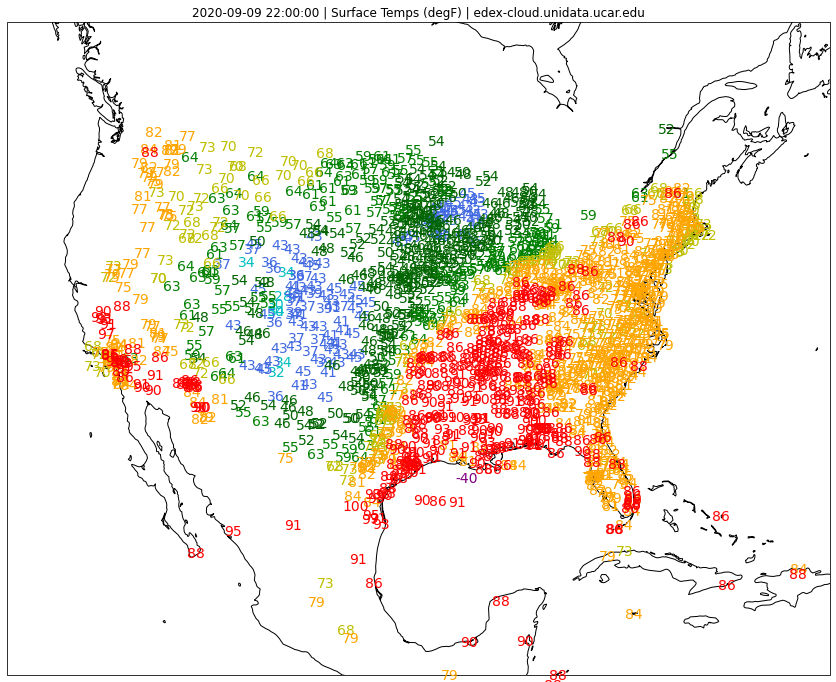

In [1]:
from awips.dataaccess import DataAccessLayer
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from datetime import datetime, timedelta
import numpy as np
import cartopy.crs as ccrs
import warnings
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from metpy.plots import StationPlot
%matplotlib inline

# CONUS bounding box and envelope geometry
bbox=[-120, -70, 15, 55]
envelope = Polygon([(bbox[0],bbox[2]),(bbox[0],bbox[3]),
                    (bbox[1], bbox[3]),(bbox[1],bbox[2]),
                    (bbox[0],bbox[2])])

# New obs request
edexServer = "edex-cloud.unidata.ucar.edu"
DataAccessLayer.changeEDEXHost(edexServer)
request = DataAccessLayer.newDataRequest("obs", envelope=envelope)
single_value_params = ["timeObs", "stationName", "longitude", "latitude", 
                       "temperature", "dewpoint", "windDir",
                       "windSpeed", "seaLevelPress"]
multi_value_params = ["presWeather", "skyCover", "skyLayerBase"]
params = single_value_params + multi_value_params
request.setParameters(*(params))

# Get records from the last 15 minutes
lastHourDateTime = datetime.utcnow() - timedelta(minutes = 15)
start = lastHourDateTime.strftime('%Y-%m-%d %H:%M:%S')
end = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

beginRange = datetime.strptime( start , "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( end , "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)
# Get response
response = DataAccessLayer.getGeometryData(request,timerange)
obs = DataAccessLayer.getMetarObs(response)

print("Found " + str(len(response)) + " total records")
print("Using " + str(len(obs['temperature'])) + " temperature records")

# Create a station plot pointing to an Axes to draw on as well as the location of points

lats = obs['latitude']
lons = obs['longitude']

thresholds = {
    '15': 'purple',
    '25': 'c',
    '35': 'royalblue',
    '45': 'darkgreen', 
    '55': 'green',
    '65': 'y', 
    '75': 'orange',
    '85': 'red'
}

fig, ax = plt.subplots(figsize=(16,12),subplot_kw=dict(projection=ccrs.LambertConformal()))
ax.set_extent(bbox)
ax.coastlines(resolution='50m')
ax.set_title(str(response[-1].getDataTime()) + " | Surface Temps (degF) | " + edexServer)

# Suppress nan masking warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# get all temperature values and convert them from C to F
tair = np.array(obs['temperature'], dtype=float)
tair[tair == -9999.0] = 'nan'
tair = (tair*1.8)+32

for x, value in thresholds.items():
    # create a new temperature value array
    subtair = tair.copy()

    # pair down the temperature values to a subset
    if x==max(thresholds):
        subtair[(subtair < int(x))] = 'nan'
    elif x==min(thresholds):
        subtair[(subtair >= int(x)+10)] = 'nan'
    else:
        subtair[(subtair < int(x))] = 'nan'
        subtair[(subtair >= int(x)+10)] = 'nan'

    # add these stations and their color to the stationplots
    stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(), fontsize=14)
    stationplot.plot_parameter('C', subtair, color=value)
    
